In [4]:
import os
import torch
from PIL import Image
import pandas as pd 
import sys 
import json 
import importlib
from pathlib import Path 
from PIL import Image as PILImage
import numpy as np
import matplotlib.pyplot as plt

In [5]:
sys.path.append('../')
from src import dataset_lvis
from src import metrics
from src import helper_functions as helper

In [161]:
importlib.reload(dataset_lvis)
importlib.reload(helper)

<module 'src.helper_functions' from '/home/INM705/INM705_CW_Collins_Velagala/notebooks/../src/helper_functions.py'>

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [45]:
data_args = {'stage': 'val',
            'classes': ['airplane','sofa'], #, 'signboard'],
            'ds_path' : "/home/Datasets/coco/",
            'labels_dir': "annotations",
            'images_dir': 'images',
             'height' : 480,
             'width' : 640 }
val_data = dataset_lvis.LVISData(**data_args)

Loaded 180 images!
245 annotations found!
classes : {1: 'airplane', 2: 'sofa'}
stage:  val
ds_path:  /home/Datasets/coco/
labels_f:  /home/Datasets/coco/annotations/lvis_v1_val.json
imgs_dir:  /home/Datasets/coco/images/val2017


In [46]:
#Split dataset to test and train
indices = torch.randperm(len(val_data)).tolist()


#dataset_train = torch.utils.data.Subset(val_data, indices[:150])
dataset_test = torch.utils.data.Subset(val_data, indices[150:])


#train_loader = torch.utils.data.DataLoader(
# dataset_train, batch_size=5, shuffle=True, #num_workers=4,
# collate_fn=CollateCustom())


test_loader = torch.utils.data.DataLoader(
 dataset_test, batch_size=1, shuffle=True, #num_workers=4,
 collate_fn=helper.CollateCustom())


In [47]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [49]:
num_classes = 3

#model setup 
model = get_instance_segmentation_model(num_classes)
model.to(device)

helper.load_model(model, 'model.pth')


Loaded from model model.pth!


In [50]:
model.eval() 
None

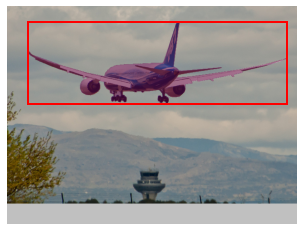

In [151]:
idx, X, y= next(iter(test_loader))
val_data.plot_img_with_ann(idx[0], bboxes = True)

In [58]:
print(y)

[{'boxes': tensor([[209.9400, 103.9575, 249.9400, 137.9575],
        [112.7625,   6.0300, 167.7625,  64.0300]]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'labels': tensor([1, 1])}]


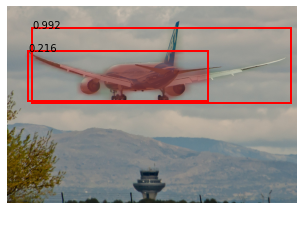

In [152]:
y_pred = model(X.to(device))
val_data.plot_predictions(idx[0], y_pred)

In [61]:
preds

tensor([[210.7499, 105.3304, 250.4160, 138.1767],
        [113.7709,   9.1044, 167.6042,  61.5928]])

In [60]:
gts = y[0]['boxes']#[0]
preds = y_pred[0]['boxes'].to('cpu').detach()#[0]"

for i in range(len(gts)):
    gt = gts[i]   
    IOU = metrics.get_iou(preds, gt)
    print(IOU)

tensor([[0.9237],
        [0.0000]])
tensor([[0.0000],
        [0.8858]])


In [66]:
temp_preds= {} 
temp_gt = {} 


In [153]:
temp_preds[idx[0]] = y_pred[0]
temp_gt[idx[0]] = y[0]

In [163]:
gts, preds = helper.filter_to_label(temp_preds, temp_gt, 1) 
print(gts) 
print(preds)

[[85, [tensor([209.9400, 103.9575, 249.9400, 137.9575]), tensor([112.7625,   6.0300, 167.7625,  64.0300])]], [146, [tensor([ 46.4200,  34.0800, 617.4200, 214.0800])]]]
[[85, tensor([0.9950, 0.9929]), tensor([[210.7499, 105.3304, 250.4160, 138.1767],
        [113.7709,   9.1044, 167.6042,  61.5928]])], [146, tensor([0.9920, 0.2155]), tensor([[ 55.2928,  47.5999, 626.6821, 212.9283],
        [ 46.0015,  97.3018, 442.9441, 208.9994]])]]
